#Lecture 16: GA and SGD

AM207: Verena Kaynig-Fittkau,and Pavlos Protopapas, Harvard University

------


# Announcements

### Final Project Schedule:
- March 27 -- April 06: Talk to TFs and come up with a proposal
- April 10: Proposals are due
- **~~April 29: Submit your project notebook/paper (6 pages)~~**
- May 4 or earlier: Print your poster
- Show off at SEAS and IACS Science Fair and get feedback:
    - SEAS: May 6th
    - IACS: May 7th

- May 12: Submit your project notebook/paper (6 pages) and screencast (3min), and optional: webpage

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

import time

from IPython import display

from IPython.core.display import Image

# Introduction
In this lecture we will cover the Genetic Algorithm.  Like simulated annealing, the genetic algorithm is a stochastic search method, however, the genetic algorithm is motivated not by physics but by biology - specifically the evolutionary process. The main features of a GA approach are:

1. We work with an abstract representation of the system, and not the physical system itself (often the representation is a sequence of numbers representing the various components of the system).
2. We create several slightly different representations of the system, called a population, and improve the whole population rather than a single individual.
3. We must use a method (function) which, given an individual, produces a single value that characterizes the “fitness” of this individual, called the “fitness” function.
4. We perform some operations on the individuals of the population which gradually lead to a population of higher average fitness.


The operations we perform, which are all of stochastic nature are the following:

**Reproduction**: given a population and the fitness of each member of the population, we update the population in such a manner that on average the members of higher fitness have more offspring, that is, the new population has more members of the type that has higher fitness. Reproduction (“survival of the fittest”) takes place at every step, going from one generation to the next.  Note that the population size $N$ does not change between generations.  $N=10$ is often a good choice when tackling an initial problem, but can be increased depending on the complexity problem.

**Crossover**: some randomly selected members of a population are cut at some random point and the remainders are exchanged. Crossover takes place with high probability $p_c$, typically $p_c \sim 1$.

**Mutation**: some random site of a random member of the population undergoes a random change in its value. Mutation takes place with very low probability $p_m$, typically $p_m \sim 0.001$.


# Understanding Reproduction
The first task in implementing the GA is to select the fitness function.  The good news is the fitness function is really just a biology-inspired name for an objective function in an optimization problem.  For example, in the Traveling Salesman problem we discussed before break, we are attempting to minimize the time the salesman spends traveling and thus the fitness function will be the time the salesman spends traveling.  Note that while often in optimization literature, the optimization problem is cast as a minimization problem, we always try to **maximize** fitness (simply flip the sign of the objective function accordingly).  

Our goal of course is to find the set of parameters that maximizes fitness.  Each set of parameters is what we will call an individual in the population.  For a population with members $s_n, n=1, ..., N$ we define the total fitness of the population:

$$F = \sum_{n=1}^N f_n$$

and the scaled fitness of each member:

$$\tilde f_n = \frac{f_n}{F}$$

and the incremental scaled fitness

$$\tilde g_m = \sum_{n=1}^m \tilde f_n $$

with the additional definition $\tilde g_0=0$. From these definitions it is evident that: 

$$\tilde g_N = \sum_{m=1}^N \tilde f_n =1 $$

To implement reproduction, we generate $r_n, n=1, ...,N$ random numbers between 0 and 1; for a random number $r_n$ falling in the interval between $\tilde g_{m-1}$ and $\tilde g_m$ with $m=1,...,N$ we assign the new member $s_n$ to be equal to the old member $s_m$:

$$\tilde g_{m-1}< r_n < \tilde g_m \rightarrow s_n^{\text{(new)}} =s_m^{\text{(old)}}$$

with the superscripts "old" and "new" referring to the member of the population before and after the reproduction step.  From this procedure, we expect that when the difference between two consecutive values of the incremental scaled fitness is large, there is high probability to find a larger proportion of the random numbers $r_n$ in this interval; but from the definition of the incremental scaled fitness we have:

$$\tilde g_m - \tilde g_{m-1} =\tilde f_m$$

Therefore, on average members with high fitness will acquire more offspring, exactly as reproduction is supposed to work!






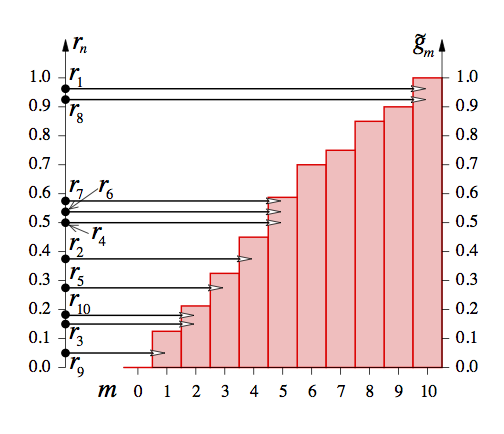

In [69]:
Image('./images/FitnessFig.png', width=600)

##Example

We will use the genetic algorithm to minimize Rastrigin's function defined as:

$$Ras(x)=20+x_1^2+x_2^2-10\,[\cos(2\pi x_1)+\cos(2\pi x_2)]$$

As can be seen from the plot below, this function contains many local minima but just one global minimum at $[0,0]$. The many valleys in the plot make it difficult for traditional gradient based methods (which we will introduce later in this lecture) to find the global minimum, but GA makes quick work of the minimization.

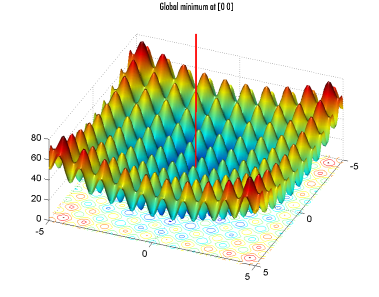

In [70]:
Image('./images/rastrigins_with_line2.png', width=600)

  

Because we want our fitness function to increase as the value of the Ras function decreases, we define our fitness function to be $Ras(x)^k$ where $k<0$.  In the code below we call $k$ the 'fitness scale' and set $k=-0.5$. We will use a population size of 10 and go through 1000 generations of evolution, selecting the best solution from all individuals covered.  Note the genetic algorithm is not strictly decreasing over time.

For crossover, we will randomly select two individuals in each population and flip their $x_2$ values.  For mutation, we define two types of mutation: big and small.  A "big mutation" makes a change of $\Delta$ to an element of an individual in the population where $\Delta$ is drawn from a normal distribution with mean 0 and standard deviation here of 1 (the std is subjective).  A "small mutation" is defined similarly but is drawn from a normal distribution with standard deviation of 0.05.  We set the probability of a big mutation as 0.05 and that of a small mutation of 0.4.

In [6]:
# Returns the additive inverse of the Rastrigin Function
start_time = time.clock()

p_big_mutate = 0.05
p_small_mutate = 0.4

fitness_scale=-0.5
pop_size=100
generations = 10**4
std_big = 1
std_small= 0.05

def ras_fitness(g):
    ans = 20+g[:,0]**2+g[:,1]**2-10.0*(np.cos(2*np.pi*g[:,0])+np.cos(2*np.pi*g[:,1]))
    return ans**fitness_scale

def transform(population_orig):
    # select two individuals for recombination
    population =population_orig.copy()
    indices = range(pop_size)
    np.random.shuffle(indices)
    temp = population[indices[0],1]
    population[indices[0],1] = population[indices[1],1]
    population[indices[1],1] = temp
    
    #perform mutation
    for i in range(pop_size):
        if np.random.rand() < p_big_mutate:
            population[i,0] = population[i,0]+std_big*np.random.randn()
        if np.random.rand()<p_small_mutate:
            population[i,0] = population[i,0]+std_small*np.random.randn()
        if np.random.rand()<p_big_mutate:
            population[i,1] = population[i,1]+std_big*np.random.randn()
        if np.random.rand()<p_small_mutate:
            population[i,1] = population[i,1]+std_small*np.random.randn()
            
    return population


#generates initial population
mean=[100,100]
cov=[[9,0],[0,9]]
g_0 = np.random.multivariate_normal(mean,cov,pop_size)
                                
generation_fitness = np.zeros(generations)
#put placeholder for optimal solution
optimal_sol = [-100,-100]
    
g_curr=g_0

for z in range(generations):
    
    if not z==0:
        g_curr = transform(g_curr)
        
    fit_curr = ras_fitness(g_curr)
    generation_fitness[z] = fit_curr.max()
    
    if z==0:
        optimal_sol = g_curr[np.argmax(fit_curr),:]
    elif generation_fitness[z]>generation_fitness[z-1]:
        optimal_sol = g_curr[np.argmax(fit_curr),:]
       
    marg_fit = fit_curr.cumsum()/fit_curr.sum()
    r=np.random.rand(pop_size)
    counts=np.zeros(pop_size)

    for i in range(pop_size):
        counts[i] = np.sum(marg_fit<=r[i]) 

    child_counts = counts
    
    g_new = []
    
    for i in range(pop_size):
        g_new.append(g_curr[child_counts[i],:])
    
    g_curr=np.array(g_new)

end_time = time.clock()

[ -2.30299653e-08  -3.02733530e-07]
12.96452696


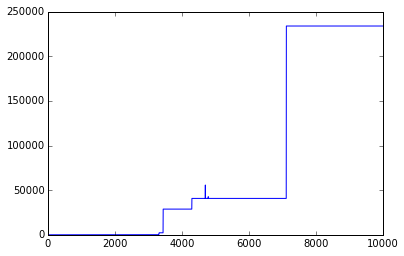

In [7]:
print optimal_sol
print end_time - start_time
plt.plot(generation_fitness)
plt.show()

As we can see in just 1000 generations we reached a pretty good solution. The above plot shows the evolution of generational fitness over time where we define generational fitness to be the fitness of the most fit individual in that generation.  Note that the reason the plot is so choppy is because of our high mutation rates.  With a smaller mutation rate, we would expect to see a much more stable approach to a maximal fitness value and a rough plateau as we near the optimal value.

#Gradient Descent
The final stochastic optimization method we will introduce is called "Stochastic Gradient Descent."  This method is a modification of the deterministic "Batch Gradient Descent" method, which we now introduce.

Assume that we have a vector of paramters $\theta$ and a cost function $J(\theta)$ which is simply the variable we want to minimize (our objective function). Typically, we will find that the objective function has the form

$$J(\theta) =\sum_{i=1}^m J_i(\theta)$$

where $J_i$ is associated with the i-th observation in our data set.  The batch gradient descent algorithm, starts with some initial feasible $\theta$ (which we can either fix or assign randomly) and then repeatedly performs the update:

$$\theta := \theta - \alpha \nabla J(\theta) = \theta -\alpha \sum_{i=1}^m \nabla J_i(\theta)$$

where $\alpha$ is a constant controlling step-size.  Note that this algorithm makes intuitive sense as it always proceeds in the direction of steepest descent (the gradient of $J$) and guarantees that we find a local minimum (global under certain assumptions on $J$).  When we have very large data sets however the calculation of $\nabla (J(\theta))$ can be costly as we must process every data point before making a single step (hence the name "batch").  An alternative approach, the stochastic gradient descent method, is to update $\theta$ sequentially with every observation.  The updates then take the form:

$$\theta := \theta - \alpha \nabla J_i(\theta)$$

This stochastic gradient approach allows us to start making progress on the minimization problem right away.  Generally, the stochastic gradient descent method will get close to the optimal $\theta$ much faster than the batch method, but will never fully converge to the local (or global) minimum. Thus the stochastic gradient descent method is useful when we want a quick and dirty approximation for the solution to our optimization problem.  A full recipe for stochastic gradient descent follows:

1. Initialize the parameter vector $\theta$ and set the learning rate $\alpha$
2. Repeat 3-5 until an acceptable approximation to the minimum is obtained.
3. Randomly reshuffle the instances in the training data.
4. For $i=1,2,...m$ do: $$\theta := \theta - \alpha \nabla J_i(\theta)$

### Example: Linear Regression
Let's see briefly how gradient descent can be useful to us in least squares regression.  Let's asssume we have an output variable $y$ which we think depends linearly on the input vector $x$.  We approximate $y$ by 

$$f_\theta (x) =\theta^T x$$

The cost function for our linear least squares regression will then be 

$$J(\theta) = \frac{1}{2} \sum_{i=1}^m (f_\theta (x^{(i)}-y^{(i)})^2$$

In this linear example it's easy to see that our update step then takes the form:

$$\theta_j := \theta_j + \alpha \sum_{i=1}^m (y^{(i)}-f_\theta (x^{(i)})) x_j^{(i)}$$

for every $j$ (note $\theta_j$ is simply the j-th component of the $\theta$ vector).

Similarly, the update equation in step 4 of the stochastic gradient descent method is 

$$\theta_j := \theta_j + \alpha (y^{(i)}-f_\theta (x^{(i)})) x_j^{(i)}$$

We will leave it to you to implement the batch and stochastic gradient descent methods fully as a homework excercise.


### Theano 

A really nice library for stochastic gradient decent is [theano](http://deeplearning.net/software/theano/). It can calculate _symbolic_ derivatives for you! It is mainly aimed at training deep neural networks, but you can use it to optimize whatever you want with SGD. 